In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from pyqtorch.core.circuit import QuantumCircuit
from pyqtorch.ansatz import AlternateLayerAnsatz
from pyqtorch.embedding import SingleLayerEncoding
from pyqtorch.core.operation import Z, RX

/home/aag/anaconda3/envs/pynn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Solve MIS for QAOA

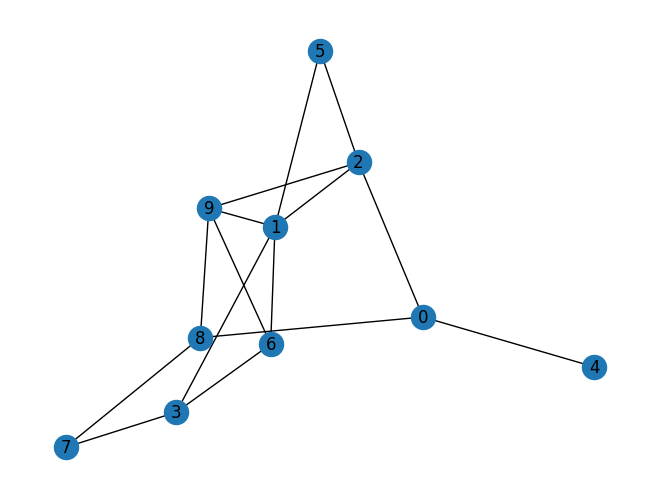

In [2]:
n_nodes = 10

graph = nx.gnp_random_graph(n_nodes, .25, seed=42)
nx.draw(graph, with_labels=True)

In [3]:
from pyqtorch.matrices import generate_ising_from_graph, sum_N
ising_matrix = generate_ising_from_graph(graph, type_ising='N')
ising_cost = 1.2*ising_matrix - sum_N(n_nodes)

ising_matrix = ising_matrix.reshape([2] * n_nodes + [1])
ising_cost = ising_cost.reshape([2] * n_nodes + [1])


class MIS(QuantumCircuit):
    def __init__(self, n_qubits, n_layers):
        super().__init__(n_qubits)
        self.beta = nn.Parameter(torch.empty(n_layers,))
        self.gamma = nn.Parameter(torch.empty(n_layers,))
        self.reset_parameters()
        
    def reset_parameters(self):
        init.uniform_(self.beta, -2 * np.pi, 2 * np.pi)
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)
        
    def forward(self, return_cost=False):
        state = self.uniform_state()
        for b, g in zip(self.beta, self.gamma):
            state = state * torch.exp(-1j * g * ising_matrix)
            for i in range(self.n_qubits):
                state = RX(b, state, [i], self.n_qubits)
        if return_cost:
            return torch.real(torch.sum(torch.abs(state)**2 * ising_cost))
        else:
            state = state.reshape((2**self.n_qubits,))
            return torch.abs(state)**2

In [14]:
model = MIS(n_nodes, 20)

optimizer = torch.optim.Adam(model.parameters(), lr=.02)
epochs = 100


for epoch in range(epochs):
    optimizer.zero_grad()
    loss = model(True)
    loss.backward()
    optimizer.step()
    if epoch%50 == 0:
        print(f"Epoch {epoch} | Loss {loss}")

Epoch 0 | Loss -0.48835717149411473
Epoch 50 | Loss -1.0927313160094916


In [5]:
prob = model()
mis = torch.argmax(prob)
format(mis, '010b')

'0001010010'

In [6]:
mis

tensor(82)

In [7]:
"{0:b}".format(1)

'1'

In [8]:
sum_N(n_nodes)[mis]

tensor(3.+0.j, dtype=torch.complex128)